In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

from JUSUFlike.Project.Codes.processing_results import *
from IPython.display import Image
import tvb_model_reference.src.nuu_tools_simulation_human as tools
from sklearn.cluster import KMeans
from scipy import signal

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

fig_labels = ['$S$', '$b_e$ (pA)', '$E_{L,i}$ (mV)', '$E_{L,e}$ (mV)', '$T$ (ms)']

/home/master/anaconda3/lib/python3.9/site-packages/tvb/datatypes/surfaces.py:63: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


# Obtain the Structural Connectivity Matrix

In [2]:
from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin import Parameter
parameters = Parameter()
file_name = '/media/master/Nuevo vol/Internship/Data/BOLD/'
parameters.parameter_simulation['path_result'] = file_name
simulator = tools.init(parameters.parameter_simulation, parameters.parameter_model,
                       parameters.parameter_connection_between_region,
                       parameters.parameter_coupling,
                       parameters.parameter_integrator,
                       parameters.parameter_monitor)

weights_mat = np.array(simulator.connectivity.weights)
print(weights_mat.shape)

(68, 68)


# Make a filtering function for the BOLD signals

In [24]:
import scipy.signal as spsg
import scipy.stats as stt
from scipy import stats

# Time resolution for fMRI signals (in seconds)
def filtering_BOLD(BOLD):
    '''Filters the input BOLD signals which are (nregions, ntimebins) and transforms them to zscore'''
    TR = 2
    
    # Filter the BOLD signals between 0.01 and 0.2 Hz
    n_order = 2
    Nyquist_freq = 0.5 / TR
    low_f = 0.01 / Nyquist_freq
    high_f = 0.1 / Nyquist_freq
    b, a = spsg.iirfilter(n_order, [low_f,high_f], btype='bandpass', ftype='butter')
    
    BOLD_filt = spsg.filtfilt(b, a, BOLD, axis=-1)
    BOLD_filt_zscore = stats.zscore(BOLD_filt)
    return BOLD_filt_zscore

# Also a function to get_results from BOLD monitor

In [25]:
def get_result_BOLD(file_path, run_sim, cut_transient, BOLD_TR=2000.0, nregions=68):
    '''Obtains the BOLD signals from the saved files after the TVB simulation.
    
    Only works when only BOLD signals have been generated, if other monitors have been
    used, look at the comment # * where the indexes will have to be changed
    
    Inputs:
        file_path: str
            Path to the simulated files.
            
        run_sim: float, int
            How long the simulation has been run, in ms
            
        cut_transient: float, int
            How much time after starting the simulation one discards as transient
            
        BOLD_TR: float, int
            Repetition Time (TR) of BOLD signal. Sampling period in ms, typically 2000ms.
        
        nregions: int
            Number of different signals produced. Number of regions in the TVB parcellation.
    
    Outputs:
        times: 1D array (typically ntimebins = (run_sim - cut_transient) / BOLD_TR elements)
            Containing the time at which each sample of the BOLD signal has been taken.
            
        BOLD: 2D array of shape (nregions, ntimebins)
    '''
    times = np.arange(0, run_sim, BOLD_TR)
    BOLD = np.zeros((nregions, times.size))
    for step, time in enumerate(times):
        result = np.load(file_path + f'/step_{step}.npy', allow_pickle=True)[0][0] # * probably change indexes
        BOLD[:, step] = result[1][0, :, 0]
    # Now cut transient
    times = times[int(cut_transient / BOLD_TR):] / 1000  # To have it in seconds
    BOLD = BOLD[:, int(cut_transient / BOLD_TR):]
    
    return times, BOLD

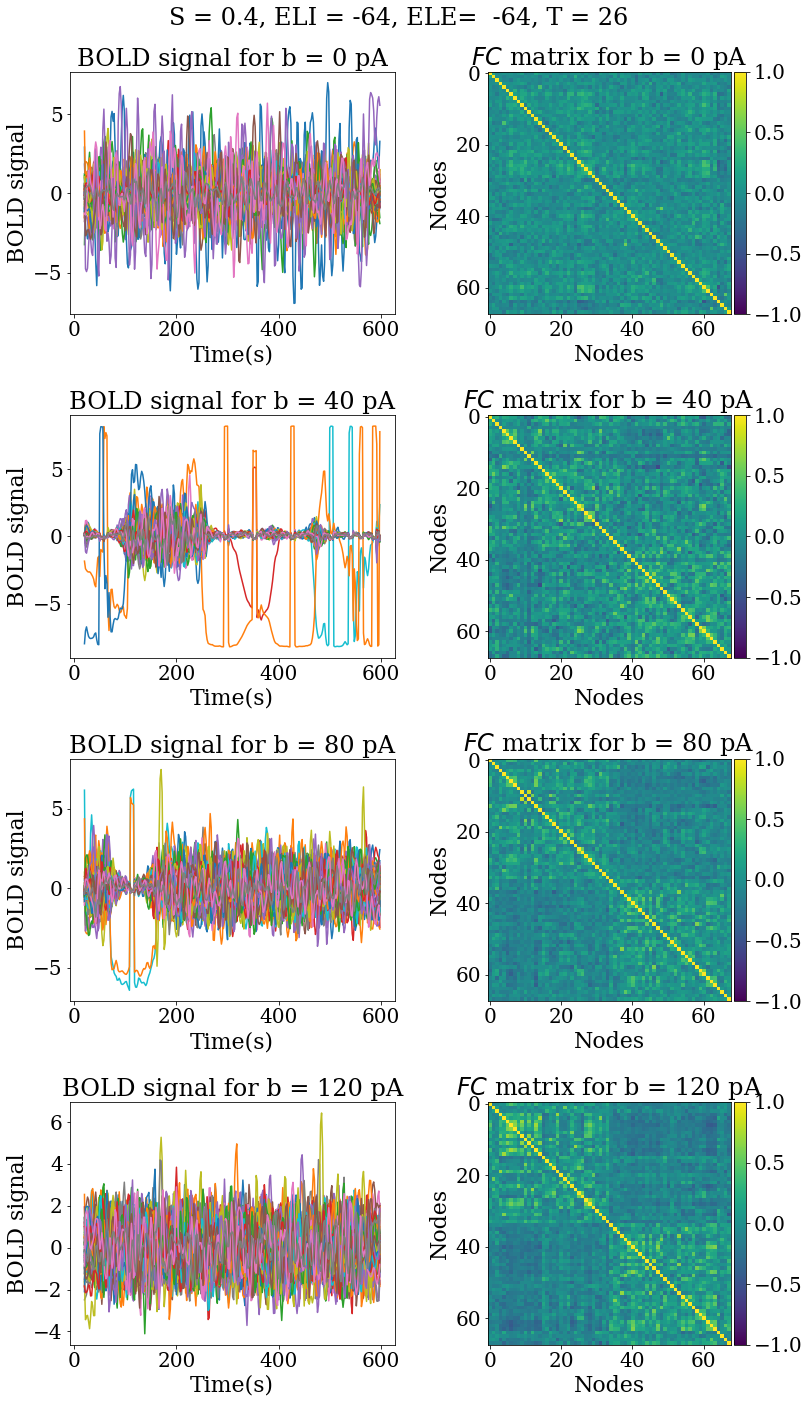

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
run_sim = 600000.0
cut_transient = 20000.0

folder_root = '/media/master/Nuevo vol/Internship/Data/BOLD/'

file_name_nob = '_a_0.4_ELI_-64_ELE_-64_T_26_b_'
suptitle = 'S = 0.4, ELI = -64, ELE=  -64, T = 26'
bs = [0, 40, 80, 120]
corrcoeff = np.zeros(4)
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
fig.suptitle(suptitle)
for ii, b in enumerate(bs):
    ax = axes[ii, 0]
    
    file_name = folder_root + file_name_nob + str(b)
    # Get the matrices first and then fill them up. Menuda mierda que no vaya esto
    times, BOLD = get_result_BOLD(file_name, run_sim, cut_transient)
    BOLD = filtering_BOLD(BOLD)
    
    ax.plot(times, BOLD.T)
    ax.set(xlabel='Time(s)', ylabel='BOLD signal', title=f'BOLD signal for b = {b} pA')
    
    ax = axes[ii, 1]
    FC = np.corrcoef(BOLD)
    corrcoeff[ii] = np.corrcoef(x=FC.flatten(), y=weights_mat.flatten())[0, 1]
    im = ax.imshow(FC, vmin=-1, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set(title=f'$FC$ matrix for b = {b} pA', xlabel='Nodes', ylabel='Nodes')

plt.tight_layout()
plt.show()

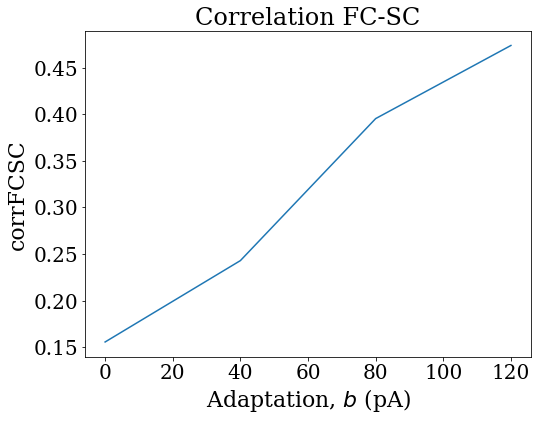

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(bs, corrcoeff)
ax.set(title='Correlation FC-SC', xlabel='Adaptation, $b$ (pA)', ylabel='corrFCSC')
plt.show()

# Do more simulations with less possibilities of explosion

In [28]:
bs = [0, 20, 40, 60, 80, 100, 120]
print(len(bs))

7
